In this homework you'll train a simple image classifier using using Pytorch. If you're not familiar with Pytorch please take a look at our [introduction to Pytorch notebook](https://colab.research.google.com/drive/1GO_YSErd9TjiH0R-hZ2XkKIfMbQK9Ask?usp=sharing). There are four parts to the homework:

1. Dataset class: you'll create a custom dataset class that you'll use to load the images for training. Your image transformations should be done in the dataset class.

2. Model design: in this section you'll design a simple CNN based model architecture to learn to predict image classes correctly.

3. Model training: train an image classifier using the model you designed in step 2. You'll need to instantiate a dataloader that uses an instance of your dataset class to iterate through the dataset for training.

4. Evaluation: load your model's weight and run inference on the dataset and report your result

In [1]:
import os
import tarfile

if not os.path.isfile('./data.tar.gz'):
    !wget 'http://cs.umd.edu/~pulkit/hw_3_data.tar.gz' -O data.tar.gz

with tarfile.open('./data.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./')


--2024-05-03 01:29:53--  http://cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving cs.umd.edu (cs.umd.edu)... 128.8.127.4
Connecting to cs.umd.edu (cs.umd.edu)|128.8.127.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz [following]
--2024-05-03 01:29:53--  http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving www.cs.umd.edu (www.cs.umd.edu)... 128.8.127.4
Reusing existing connection to cs.umd.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 7171530 (6.8M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   6.84M  4.48MB/s    in 1.5s    

2024-05-03 01:29:55 (4.48 MB/s) - ‘data.tar.gz’ saved [7171530/7171530]



## Dataset class

In [27]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
import os


class CustomImageDataset(Dataset):
    def __init__(self, csv_path, data_root, transform=None, device='cpu'):
        self.transform = transform
        self.root_path = data_root
        self.device = device

        # TODO: Read the csv file. You can use the pandas library
        data = pd.read_csv(csv_path)

        # TODO : Get the image paths from the csv
        self.image_paths = data['image_path'].tolist()

        # TODO: Get the class ids from the csv. You might want to check if the class_id
        # column exists in the csv before trying to get it. The test csv does not have
        # the class_id column
        if 'class_id' in data.columns:
            self.class_ids = data['class_id'].tolist()
        else:
            self.class_ids = None

        # TODO: Get the image names from the csv. This is required for the test part at
        # the end of the notebook. You should only return the image name for testing,
        # otherwise you should return the image and the class id
        if 'image_name' in data.columns:
            self.image_names = data['image_name'].tolist()
        else:
            self.image_names = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        rel_img_path = self.image_paths[idx]
        image_name = self.image_names[idx]

            # TODO: Read the image file
        img = cv2.imread(rel_img_path)
        # TODO Apply transformations if any to the image. You will want to at least convert
        # the image to a tensor. You can also apply other transformations.

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transforms.ToTensor()(img)
            img = normalize(img)

        if self.class_ids is None: # for testing purposes
            return img, image_name, rel_img_path
        else:
            class_id = torch.tensor(self.class_ids[idx], dtype=torch.long)
            return img.to(self.device), class_id.to(self.device)

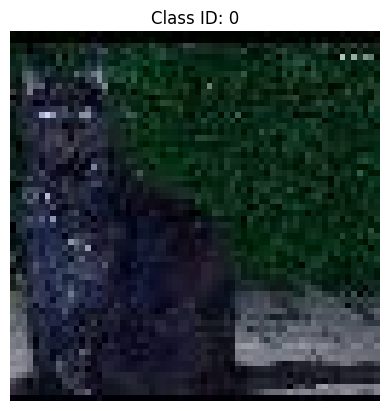

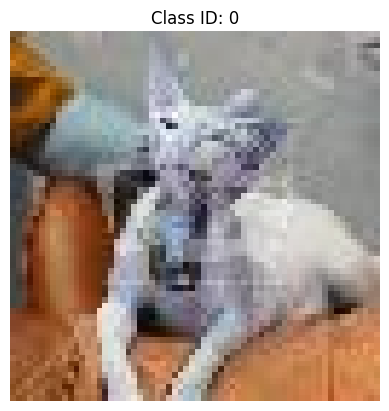

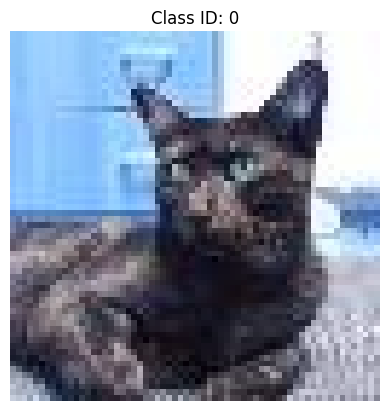

In [28]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms as T
import numpy as np
def plot_image(img, title=None):

    img = (img * 255).astype(np.uint8)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

csv_path = "/content/data/csvs/train.csv"
data_root = '/content/data/train'
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = CustomImageDataset(csv_path, data_root, transform)

for i in range(3):
    img, class_id = dataset[i]
    img = unnormalize(img)
    plot_image(img, title=f'Class ID: {class_id}')

### Model definition

Define your image classifier model here. Since we're working with images, you should consider an convolution neural network type model architecture. Start simple and make it more complex if you need to once you have something working.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, n_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Training

In [82]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Feel free to try other batch sizes. The batch size is usually a power of 2.
batch_size = 4

# You can try other learning rates to see how it affects the training.
learning_rate = 1e-4

# Try to explore different transformation functions. You can use transformations
# to make your model more robust to translation, color changes etc. This is a good
# article that explains some transformations available in Pytorch
# https://pytorch.org/vision/stable/transforms.html. You can use transformations
# to augment/"increase" your training data.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_root = "./"

# TODO: Create an instance of the CustomImageDataset class for the training and validation datasets
train_set = CustomImageDataset(csv_path='/content/data/csvs/train.csv', data_root='/content/data/train', transform=transform)
val_set = CustomImageDataset(csv_path='/content/data/csvs/val.csv', data_root='/content/data/val', transform=transform)

# TODO: Create two dataloaders for bothe datasets.
# TODO: Shuffle the training dataloader. This is important to prevent the model from learning the order of the data.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# TODO: Initialize your model
n_classes = 10
model = ImageClassifier(n_classes=n_classes).to(device)

# TODO: Initialize the optimizer. Feel free to try other optimizers in the torch.optim
# module.
# Hint: the Adam optimizer and its variants are the staple these days.
optimizer = Adam(model.parameters(), lr=learning_rate)

# TODO: Instantiate the loss function.
# Hint: Cross entropy loss works great for classification tasks like this one.
# Reading up on what loss function to use for what task could be informative
loss_fn = nn.CrossEntropyLoss()

# Training loop
eval_every = 2

# Consider training for longer. Keep an eye on the validation loss and decide
# on what works best for you.
n_epochs = 10
val_loss_values = []
training_loss_values = []
eval_epochs = []

# Early stopping initialization
best_val_loss = float('inf')
patience = 0
max_patience = 3



for epoch in range(n_epochs):
    # set your model to training mode. This is important if you're using normalization
    # or dropout
    model.train()
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # TODO: Make a forward pass (predict the class of the image)
        pred = model(img)

        # Calculate the loss
        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()

    # Validation loop
    if epoch > 0 and epoch % eval_every == 0:
        model.eval()
        val_loss = 0

        # don't calculate gradients when evaluating your model
        with torch.no_grad():
            for img, label in tqdm(val_loader):
                img, label = img.to(device), label.to(device)
                pred = model(img)
                val_loss += loss_fn(pred, label).item()

        print(f"Epoch: {epoch}, Train Loss: {loss.item()} Eval Loss: {val_loss / len(val_loader)}")
        eval_epochs.append(epoch)
        training_loss_values.append(loss.item())
        val_loss_values.append(val_loss / len(val_loader))

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
        if patience > max_patience:
            print("Early stopping due to validation loss not improving")
            break

# Save your model's weights
torch.save(model.state_dict(), "model.pth")

100%|██████████| 125/125 [00:00<00:00, 375.44it/s]


Epoch: 2, Train Loss: 1.574599027633667 Eval Loss: 1.407231436252594


100%|██████████| 125/125 [00:00<00:00, 404.03it/s]


Epoch: 4, Train Loss: 1.9374089241027832 Eval Loss: 1.3246377021074296


100%|██████████| 125/125 [00:00<00:00, 389.63it/s]


Epoch: 6, Train Loss: 0.23804396390914917 Eval Loss: 1.335661179766059


100%|██████████| 125/125 [00:00<00:00, 401.91it/s]


Epoch: 8, Train Loss: 0.26503056287765503 Eval Loss: 1.4184211286082864


100%|██████████| 750/750 [00:04<00:00, 162.58it/s]


### Plot your training and validation loss

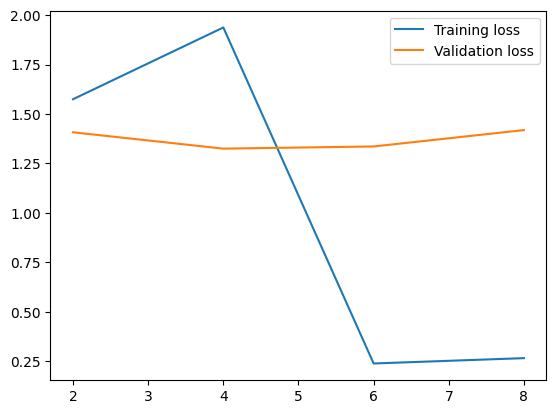

In [83]:
# Plot the training and validation loss
plt.plot(eval_epochs, training_loss_values, label='Training loss')
plt.plot(eval_epochs, val_loss_values, label='Validation loss')
plt.legend()
plt.show()

### Test your model against the validation dataset
This should give you a rough idea on how your model will do on the test set that you don't have labels for.
This section is not required and is only provided as a sanity check for you

In [84]:
## Load from your saved model
import numpy as np
import torch

# Load from your saved model using torch.load
model_state_dict = torch.load("./model.pth")
model = ImageClassifier(n_classes=n_classes).to(device)
model.load_state_dict(model_state_dict)

# set model to inference mode
model.eval()
batch_size = 1

# Load the validation dataset
img_root = "/content/data/val"
test_dataset = CustomImageDataset(csv_path='/content/data/csvs/val.csv', data_root=img_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

preds = []
model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        # TODO: predict the classes of the images and append them to the preds list
        img = img.to(device)
        # Predict the classes of the images and append them to the preds list
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())

# Get the true labels for the validation dataset
true_labels = [label for _, label in test_dataset]

accuracy = (np.array(true_labels) == np.array(preds)).mean()
print(f"Accuracy: {accuracy}")

100%|██████████| 500/500 [00:00<00:00, 840.29it/s]


Accuracy: 0.556


In [ ]:
print(len(true_labels))


1500


### Evaluation
Evaluate your model on the test dataset and create a CSF file. This is the file you need to submit.
> Important: make sure the prediction file has the columns: image_name, prediction, image_path

In [85]:
## Load from your saved model
import numpy as np
import torch

# Load from your saved model using torch.load
model_state_dict = torch.load("./model.pth")
model = ImageClassifier(n_classes=n_classes).to(device)
model.load_state_dict(model_state_dict)

# set model to inference mode
model.eval()

# Load the test data
img_root = "/content/data/test"
test_dataset = CustomImageDataset(csv_path='/content/data/csvs/test.csv', data_root=img_root, transform=transform)
# TODO: Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# TODO: Predict and save output to a CSV file. We are just looking for the top class predicted
# Hint: Lookup argmax.
final_preds = []

with torch.no_grad():
    for img, img_names, img_paths in tqdm(test_loader):
        img = img.to(device)
        # Predict the classes of the images
        outputs = model(img)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.cpu().numpy().tolist()

        # For every element in the batch, get its predicted class id in `pred`
        # Class ID will be in int.
        batch_preds = [
            (img_name, pred_img, img_path)
            for (img_name, pred_img, img_path) in zip(img_names, pred, img_paths)
        ]
        final_preds.extend(batch_preds)

100%|██████████| 1500/1500 [00:01<00:00, 863.60it/s]


In [86]:
# DO NOT MODIFY
test_prediction = pd.DataFrame(final_preds, columns=['image_name', 'prediction', 'image_path'])
test_prediction.to_csv('prediction.csv')

# You can comment these lines out if you're running the notebook locally
from google.colab import files
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload *prediction.csv* on gradescope